In [8]:
# hide
%reload_ext autoreload
%autoreload 2

In [13]:
import random

import numpy as np
import pandas as pd
import torch
from clientClass import Client

# del sys.modules['cryptotree.tree']
# del sys.modules['cryptotree.preprocessing']
# del sys.modules['cryptotree.polynomials']
# del sys.modules['cryptotree.cryptotree']
import builtins

import tenseal.sealapi as seal
from cryptotree.cryptotree import (HomomorphicNeuralRandomForest,
                                   HomomorphicTreeEvaluator,
                                   HomomorphicTreeFeaturizer)
from cryptotree.polynomials import (plot_graph_function_approximation,
                                    polyeval_tree)
# del sys.modules['cryptotree.seal_helper']
from cryptotree.preprocessing import Featurizer
from cryptotree.seal_helper import (append_globals_to_builtins,
                                    create_seal_globals, print_ctx,
                                    print_range_ctx, print_vector)
from cryptotree.tree import (CrossEntropyLabelSmoothing, NeuralRandomForest,
                             SigmoidTreeMaker, TanhTreeMaker)
from dataFunction import data_prep, import_data, make_dummies, new_df
from fastai.basic_data import DataBunch
from fastai.metrics import accuracy
from fastai.tabular.learner import Learner
from HE_functions import *
from sklearn.ensemble import RandomForestClassifier
from torch.utils import data
import missingno as msno
# nest_asyncio.apply()
# np.random.seed(10)
# tf.random.set_seed(10)
# tff.framework.set_default_context(tff.backends.native.create_thread_debugging_execution_context(clients_per_thread=50))


# Make Dataframes for every dataset

In [14]:

cleveland = "processed.cleveland.data"
switzerland = "processed.switzerland.data"
va = "processed.va.data"
hungarian = "reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)
df_dict ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }



In [15]:
# for i in clients:
#     sample = np.random.randint(1/2*len(i.y), len(i.y))
#     print(sample)
#     print(chance_of_dead_tree(sample, sum(i.y == 0), sum(i.y == 1)))

In [16]:
torch.random.manual_seed(73)
random.seed(73)
n_clients = 4
clients = []
for i in list(df_dict.keys()):
    df = df_dict.get(i)
    df_dict[i] = new_df(df)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")
    cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
    location_data = make_dummies(location_data, cat_feat)
    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Cholesterol', 'Oldpeak']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    clients.append(Client(i, x, y, cat_feat))


# X_train, X_test, y_train, y_test = train_test_split(clients[0].X, clients[0].y, test_size=0.2, random_state=42)



Cleveland: results


Original accuracy : 0.9173553719008265
Accuracy of sigmoid  : 0.44214876033057854
Accuracy of tanh : 0.7892561983471075
Match between sigmoid and original : 0.4090909090909091
Match between tanh and original : 0.871900826446281


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.660265,0.656753,0.590164,00:00
1,0.652144,0.588202,0.770492,00:00
2,0.633273,0.543945,0.786885,00:00
3,0.610434,0.550847,0.786885,00:00
4,0.595080,0.550569,0.786885,00:00


Original accuracy : 0.9173553719008265
Accuracy : 0.7644628099173554
Same output : 0.8388429752066116
Homomorpic encryption prediction calculations ....
Neural tree prediction calculations ....
Linear prediction calculations ....


Switzerland: results


Original accuracy : 1.0
Accuracy of sigmoid  : 0.6082474226804123
Accuracy of tanh : 0.9690721649484536
Match between sigmoid and original : 0.6082474226804123
Match between tanh and original : 0.9690721649484536


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.551642,0.594277,0.840000,00:00
1,0.546673,0.513123,0.840000,00:00
2,0.498684,0.487394,0.840000,00:00
3,0.454106,0.494686,0.840000,00:00
4,0.420903,0.502052,0.840000,00:00


Original accuracy : 1.0
Accuracy : 0.9587628865979382
Same output : 0.9587628865979382
Homomorpic encryption prediction calculations ....
Neural tree prediction calculations ....
Linear prediction calculations ....


VA Long Beach: results


Original accuracy : 0.9482758620689655
Accuracy of sigmoid  : 0.23275862068965517
Accuracy of tanh : 0.7672413793103449
Match between sigmoid and original : 0.1810344827586207
Match between tanh and original : 0.8189655172413793


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.644080,0.621735,0.833333,00:00
1,0.638439,0.498569,0.833333,00:00
2,0.613094,0.509700,0.833333,00:00
3,0.611064,0.520337,0.833333,00:00
4,0.613345,0.520972,0.833333,00:00


Original accuracy : 0.9482758620689655
Accuracy : 0.7672413793103449
Same output : 0.8189655172413793
Homomorpic encryption prediction calculations ....
Neural tree prediction calculations ....
Linear prediction calculations ....


Hungary: results


Original accuracy : 0.9102564102564102
Accuracy of sigmoid  : 0.3717948717948718
Accuracy of tanh : 0.7905982905982906
Match between sigmoid and original : 0.3247863247863248
Match between tanh and original : 0.8717948717948718


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.641494,0.597326,0.677966,00:00
1,0.633505,0.536497,0.796610,00:00
2,0.606221,0.504614,0.881356,00:00
3,0.586418,0.491155,0.847458,00:00
4,0.569859,0.475152,0.864407,00:00


Original accuracy : 0.9102564102564102
Accuracy : 0.8290598290598291
Same output : 0.9188034188034188
Homomorpic encryption prediction calculations ....
Neural tree prediction calculations ....
Linear prediction calculations ....


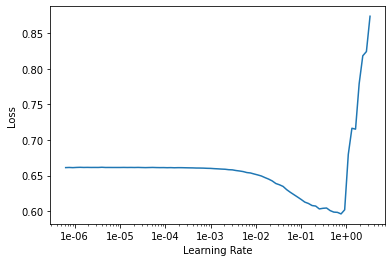

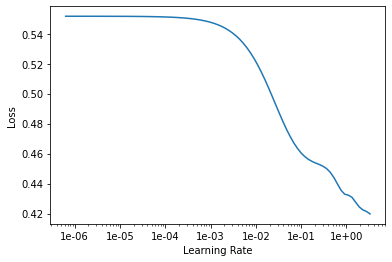

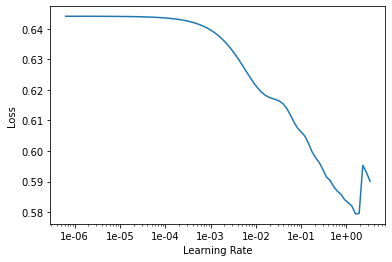

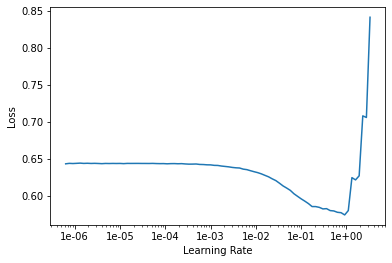

In [32]:
from HE_functions import *
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
dict_outputs = {}
dict_models = {}
feature_imp = {}
for i in clients:
    pipe = Featurizer(cat_feat)
    if i.name == 'Cleveland':
        rf, sigmoid_tree_maker, tanh_tree_maker = set_tree(5, 13)
        y_train, y_valid, X_train_normalized, X_valid_normalized = split_prep_data(i, pipe)
        train_ds, valid_ds = make_tabularDataset(X_train_normalized, y_train, X_valid_normalized, y_valid)
        train_dl, valid_dl, fix_dl = make_dataloader(train_ds, valid_ds)
        
        rf.fit(X_train_normalized, y_train)
        estimators = rf.estimators_
        print('\n')
        print(''+i.name+ ': results')
        print('\n')

        rf, sigmoid_neural_rf, tanh_neural_rf = results_trees(rf, sigmoid_tree_maker, tanh_tree_maker, X_train_normalized, y_train)
        model = fine_tune_tree(tanh_tree_maker, rf, train_dl, valid_dl, fix_dl)
        
        set_config()
        tree_evaluator, homomorphic_featurizer = setup_HE(tanh_tree_maker, model)
        dict_models['RF'] = rf
        dict_models['Sig'] = sigmoid_tree_maker
        dict_models['Tan'] = tanh_tree_maker
        dict_models['Model'] = model
    
        dict_models['RF'+i.name] = rf
        dict_models['Sig'+i.name] = sigmoid_tree_maker
        dict_models['Tan'+i.name] = tanh_tree_maker
        dict_models['Model'+i.name] = model
    else:
        rf = dict_models.get('RF')
        sigmoid_tree_maker = dict_models.get('Sig')
        tahn_tree_maker = dict_models.get('Tan')
        model = dict_models.get('Model')
        y_train, y_valid, X_train_normalized, X_valid_normalized = split_prep_data(i, pipe)
        train_ds, valid_ds = make_tabularDataset(X_train_normalized, y_train, X_valid_normalized, y_valid)
        train_dl, valid_dl, fix_dl = make_dataloader(train_ds, valid_ds)
    
        rf.fit(X_train_normalized, y_train)
        estimators = rf.estimators_
        print('\n')
        print(''+i.name+ ': results')
        print('\n')

        rf, sigmoid_neural_rf, tanh_neural_rf = results_trees(rf, sigmoid_tree_maker, tanh_tree_maker, X_train_normalized, y_train)
        model = fine_tune_tree(tanh_tree_maker, rf, train_dl, valid_dl, fix_dl)
        dict_models['RF'] = rf
        dict_models['Sig'] = sigmoid_tree_maker
        dict_models['Tan'] = tanh_tree_maker
        dict_models['Model'] = model
        dict_models['RF'+i.name] = rf
        dict_models['Sig'+i.name] = sigmoid_tree_maker
        dict_models['Tan'+i.name] = tanh_tree_maker
        dict_models['Model'+i.name] = model
        # set_config()
        tree_evaluator, homomorphic_featurizer = setup_HE(tanh_tree_maker, model)

    

    pred = rf.predict(X_train_normalized)

    with torch.no_grad():
        neural_pred = model(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

    print(f"Original accuracy : {(pred == y_train).mean()}")
    print(f"Accuracy : {(neural_pred == y_train).mean()}")
    print(f"Same output : {(neural_pred == pred).mean()}")
    # set_config()
    # tree_evaluator, homomorphic_featurizer = setup_HE(tanh_tree_maker, model)

    hrf_pred = HE_RF_pred(X_valid_normalized, homomorphic_featurizer, tree_evaluator)
    
    nrf_pred = NRF_pred(valid_dl, model)

    linear_pred = LIN_pred(X_train_normalized, y_train, X_valid_normalized)

    # We compute the random forest predictions
    rf_pred = rf.predict(X_valid_normalized)
    feature_imp[i.name] = pd.Series(rf.feature_importances_,index=i.X.columns).sort_values(ascending=False)

    models = dict(nrf=nrf_pred,hrf=hrf_pred, rf=rf_pred, linear=linear_pred)

    outputs = []
    for name, pred in models.items():
        metrics = compute_metrics(pred, y_valid)
        metrics["model"] = name
        outputs.append(metrics)
    
    outputs = pd.DataFrame(outputs)
    dict_outputs[i.name] = outputs
    # outputs
    #     for p in model.parameters():
    #         print(p.shape, p.requires_grad)

    


In [2]:
tree_evaluator

NameError: name 'tree_evaluator' is not defined

In [33]:
for i in dict_outputs.keys():
    print(i)
    print(dict_outputs[i])

Cleveland
   accuracy  precision    recall        f1   model
0  0.786885    0.62500  0.952381  0.754717     nrf
1  0.803279    0.65625  0.954545  0.777778     hrf
2  0.786885    0.78125  0.806452  0.793651      rf
3  0.786885    0.78125  0.806452  0.793651  linear
Switzerland
   accuracy  precision  recall        f1   model
0      0.84        1.0    0.84  0.913043     nrf
1      0.84        1.0    0.84  0.913043     hrf
2      0.84        1.0    0.84  0.913043      rf
3      0.84        1.0    0.84  0.913043  linear
VA Long Beach
   accuracy  precision    recall        f1   model
0  0.833333       1.00  0.833333  0.909091     nrf
1  0.833333       1.00  0.833333  0.909091     hrf
2  0.833333       0.96  0.857143  0.905660      rf
3  0.833333       0.96  0.857143  0.905660  linear
Hungary
   accuracy  precision    recall        f1   model
0  0.864407   0.789474  0.789474  0.789474     nrf
1  0.864407   0.789474  0.789474  0.789474     hrf
2  0.864407   0.789474  0.789474  0.789474      

In [36]:
for i in feature_imp.keys():
    print(i)
    print(feature_imp[i])

Cleveland
ChestPainType_4.0    0.204164
Oldpeak              0.142255
ST_Slope_2.0         0.107272
MaxHR                0.099313
ExerciseAngina       0.098143
Age                  0.080113
Sex                  0.061616
Cholesterol          0.058347
RestingBP            0.052364
ChestPainType_3.0    0.030453
ST_Slope_1.0         0.022440
ChestPainType_1.0    0.013882
RestingECG_2.0       0.013373
RestingECG_0.0       0.007652
ST_Slope_3.0         0.005728
FastingBS            0.002244
RestingECG_1.0       0.000599
ChestPainType_2.0    0.000043
dtype: float64
Switzerland
ChestPainType_2    0.173031
Age                0.150408
ChestPainType_4    0.117762
ST_Slope_2.0       0.096135
Oldpeak            0.094126
RestingBP          0.090852
MaxHR              0.088205
ChestPainType_3    0.052938
ST_Slope_1.0       0.051854
ExerciseAngina     0.027232
ST_Slope_3.0       0.024926
RestingECG_1.0     0.016086
Sex                0.015226
RestingECG_0.0     0.001219
Cholesterol        0.000000
Fas

In [37]:
for i in dict_models.keys():
    print(i)
    print(dict_models[i])

RF
RandomForestClassifier(bootstrap=False, max_depth=5, n_estimators=20,
                       random_state=2)
Sig
Tan
Model
NeuralRandomForest()
RFCleveland
RandomForestClassifier(bootstrap=False, max_depth=5, n_estimators=20,
                       random_state=2)
SigCleveland
TanCleveland
ModelCleveland
NeuralRandomForest()
RFSwitzerland
RandomForestClassifier(bootstrap=False, max_depth=5, n_estimators=20,
                       random_state=2)
SigSwitzerland
TanSwitzerland
ModelSwitzerland
NeuralRandomForest()
RFVA Long Beach
RandomForestClassifier(bootstrap=False, max_depth=5, n_estimators=20,
                       random_state=2)
SigVA Long Beach
TanVA Long Beach
ModelVA Long Beach
NeuralRandomForest()
RFHungary
RandomForestClassifier(bootstrap=False, max_depth=5, n_estimators=20,
                       random_state=2)
SigHungary
TanHungary
ModelHungary
NeuralRandomForest()


# Random forest problems

sample split gives same y values when switzerland dataset is used. Since the heartdisease variable is unevenly divided. 

P(altijd 1) bij 50 subsamples == 2% als verdeling 114 keer 1 en 8 keer 0



P(altijd 1) bij 57 subsamples == 1%

In [416]:
for i in dict_outputs.keys():
    print(i)
    print(dict_outputs[i])

Cleveland
   accuracy  precision    recall        f1   model
0  0.754098    0.78125  0.757576  0.769231     nrf
1  0.754098    0.78125  0.757576  0.769231     hrf
2  0.786885    0.78125  0.806452  0.793651      rf
3  0.786885    0.78125  0.806452  0.793651  linear
Switzerland
   accuracy  precision  recall        f1   model
0      0.84        1.0    0.84  0.913043     nrf
1      0.84        1.0    0.84  0.913043     hrf
2      0.84        1.0    0.84  0.913043      rf
3      0.84        1.0    0.84  0.913043  linear
VA Long Beach
   accuracy  precision    recall        f1   model
0  0.833333       1.00  0.833333  0.909091     nrf
1  0.833333       1.00  0.833333  0.909091     hrf
2  0.833333       0.96  0.857143  0.905660      rf
3  0.833333       0.96  0.857143  0.905660  linear
Hungary
   accuracy  precision    recall        f1   model
0  0.898305   0.736842  0.933333  0.823529     nrf
1  0.915254   0.789474  0.937500  0.857143     hrf
2  0.864407   0.789474  0.789474  0.789474      

In [25]:
y_train, y_valid, X_train_normalized, X_valid_normalized = split_prep_data(clients[1], pipe)

In [45]:
x = X_train_normalized[0]
ctx = homomorphic_featurizer.encrypt(x)
ptx = seal.Plaintext()
decryptor.decrypt(ctx, ptx)
print(ctx.save('./text'))

None


In [ ]:

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
estimator = DecisionTreeClassifier(max_depth=4, random_state=0)
estimator.fit(X_train_normalized, y_train)
fig, ax = plt.subplots(figsize = (12,8))
artists = plot_tree(estimator, ax=ax)

In [417]:
# rf, sigmoid_neural_rf, tanh_neural_rf
feature_imp = pd.Series(rf.feature_importances_,index=clients[0].X.columns).sort_values(ascending=False)
feature_imp

ExerciseAngina       0.214839
ChestPainType_3.0    0.209656
Oldpeak              0.172062
MaxHR                0.084190
Cholesterol          0.060459
ChestPainType_1.0    0.050973
Sex                  0.046161
RestingBP            0.040574
Age                  0.037622
ChestPainType_4.0    0.022065
ST_Slope_2.0         0.020519
RestingECG_0.0       0.016591
FastingBS            0.008048
RestingECG_2.0       0.006649
ST_Slope_3.0         0.005497
ChestPainType_2.0    0.003831
RestingECG_1.0       0.000233
ST_Slope_1.0         0.000031
dtype: float64

In [353]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('tab20')
plt.rcParams.update({'font.size': 16,})
num=1
f2= plt.figure(figsize=(50,30))
for i in list(df_dict.keys()):
    df = df_dict.get(i)
    for var in list(df.columns.array):
        ax = f2.add_subplot(4,5,num)
        a = np.asarray(df[var].dropna())
        ax.hist(a, bins=50, color=palette(num))
        ax.set_title(var)
        num+=1

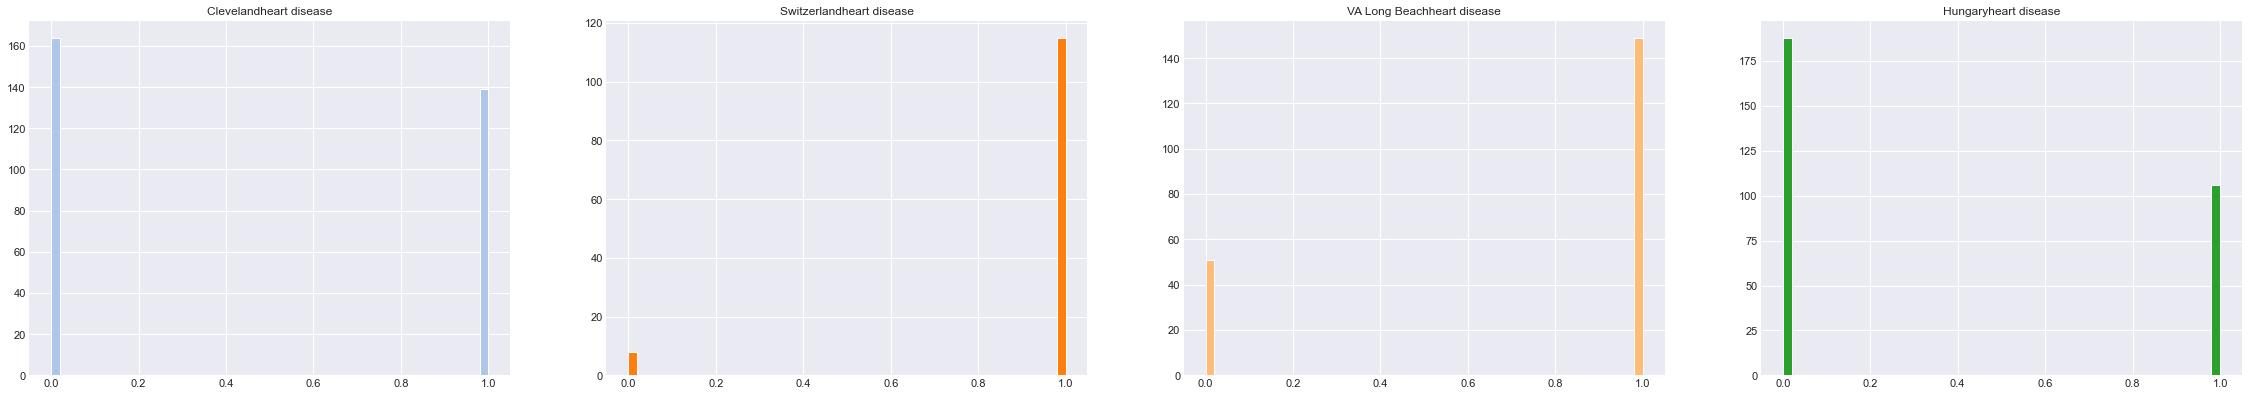

In [415]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('tab20')
plt.rcParams.update({'font.size': 16,})
num=1
f2= plt.figure(figsize=(50,30))
for i in list(df_dict.keys()):
    df = df_dict.get(i)
    # for var in list(df.columns.array):
    ax = f2.add_subplot(4,5,num)
    a = np.asarray(df.HeartDisease.dropna())
    ax.hist(a, bins=50, color=palette(num))
    ax.set_title("" + i+ "heart disease")
    num+=1

In [11]:
from testEncryp import *

# Scheme's parameters
# polynomial modulus degree
n = 2**4
# ciphertext modulus
q = 2**15
# plaintext modulus
t = 2**8
# polynomial modulus
poly_mod = np.array([1] + [0] * (n - 1) + [1])
# Keygen
pk, sk = keygen(n, q, poly_mod)
# Encryption
pt1, pt2 = 73, 20
cst1, cst2 = 7, 5
ct1 = encrypt(pk, n, q, t, poly_mod, pt1)
ct2 = encrypt(pk, n, q, t, poly_mod, pt2)

print("[+] Ciphertext ct1({}):".format(pt1))
print("")
print("\t ct1_0:", ct1[0])
print("\t ct1_1:", ct1[1])
print("")
print("[+] Ciphertext ct2({}):".format(pt2))
print("")
print("\t ct1_0:", ct2[0])
print("\t ct1_1:", ct2[1])
print("")

# Evaluation
ct3 = add_plain(ct1, cst1, q, t, poly_mod)
ct4 = mul_plain(ct2, cst2, q, t, poly_mod)

# Decryption
decrypted_ct3 = decrypt(sk, n, q, t, poly_mod, ct3)
decrypted_ct4 = decrypt(sk, n, q, t, poly_mod, ct4)

print("[+] Decrypted ct3(ct1 + {}): {}".format(cst1, decrypted_ct3))
print("[+] Decrypted ct4(ct2 * {}): {}".format(cst2, decrypted_ct4))

[+] Ciphertext ct1(73):

	 ct1_0: [ 8003 12288  7312 20931 13796  2995 23392 24235 19793 31761 23813 25047
  8063   386 11031 10247]
	 ct1_1: [31024 13434  1218 12804 15959  6800  2375 16620 19136  4258 11686 12411
  6116  4580 22771 20259]

[+] Ciphertext ct2(20):

	 ct1_0: [20513  1132 18566 18779 31369  4204 17648  2991 14919 27502 25158 12013
 20636 29739 23038  5008]
	 ct1_1: [ 6433 19061  7496  3205 30662 21254 20669 10930   284  2396 13471 20829
  2912 13797  6395  4237]

[+] Decrypted ct3(ct1 + 7): 80
[+] Decrypted ct4(ct2 * 5): 100
